23/05/19

- It looks like batched envs with 1 env works (i.e., is implemented correctly).
- Increasing the number of envs pushes off the learning spike by a factor of approximately the number of envs.
- For example, nunning num_envs=1, the spike in learning is around 1000 episodes. But with num_envs=3, its more around 3000.
- it could be the fact that the agent is running on random for longer, I should fix that
- im going to scale down n_epsilon by doing n_epsilo//num_envs, just as I did for T
- That definitely helped!
- It looks like it works with num_envs=4, im gonna try cranking it up
- it still works! lets try 10
- that hurt performance a bit, maybe lowering the learning rate?
- no that REALLY hurt performance... maybe upping it?? it might not be having enough time to explore
- wait, I may have misread my graph because the learning curve looked the same. Let me try again from num_envs=1
- okay so it looks like maybe the agent doesnt explore enough. num_envs=1 gets the best performance (around 0.7-0.8) and num_envs=2 gets almost the same, but more around 0.6-0.7. taking num_envs=3 i get 0.5-0.6 for my performance... I wonder what could be going on?
- interesting, I think it may just need longer to explore. I did n_epsilon = n_epsilon//(num_envs/2) to make the decrease in exploration time not so drastic, and it got back up to peak performance but it took a while.
- 

24/05/19

- I pip installed gym-bandits to do more testing with discrete envs.
- BanditTenArmedGaussian-v0 got around 1.25 at around 20k episodes. lets up the batches and see th effects
- interesting. it looks like it converged to 1.25 but just a bit earlier?
- okay, weird! this time with num_envs=3 it converged around the same time, but to worse performance?
- im going to see what happens if i make the epsilon_f = 0.1 to let it keep exploring rather than making it deterministic
- im also going to try doubling exploration time and we can see how that helps.
- okay instead of this, im going to improve my plotting by keeping track of rewards from each env
- but before, im going to see if the total timesteps plotted changes with multiple envs.
- it looks like with num_envs=1 i got 0.7 reward at convergence...
- okay after running some in parallel it looks like the total max reward achievable may change from env to env... i hope its not random? im gonna try this with the simple detemrinistic 2 arm bandit then try frozenlake


Environments

- BanditTwoArmedDeterministicFixed-v0: Simplest case where one bandit always pays, and the other always doesn't
- BanditTwoArmedHighLowFixed-v0: Stochastic version with a large difference between which bandit pays out of two choices
- BanditTwoArmedHighHighFixed-v0: Stochastic version with a small difference between which bandit pays where both are good
- BanditTwoArmedLowLowFixed-v0: Stochastic version with a small difference between which bandit pays where both are bad
- BanditTenArmedRandomFixed-v0: 10 armed bandit with random probabilities assigned to payouts
- BanditTenArmedRandomRandom-v0: 10 armed bandit with random probabilities assigned to both payouts and rewards
- BanditTenArmedUniformDistributedReward-v0: 10 armed bandit with that always pays out with a reward selected from a uniform distribution
- BanditTenArmedGaussian-v0: 10 armed bandit mentioned on page 30 of Reinforcement Learning: An Introduction (Sutton and Barto)


- Okay so it looks like batched learning can make the bandit envs work faster, but this might be because they only have a single timestep... it looks like doing the same with frozenlake fails. Not sure. Im going to make a version of this that includes the 'done' flags - it shouldnt matter because it seems to learn without them, but still.
- First, im going to leave the timesteps the same and see if it can learn with enough timesteps with batched envs
- okay so it looks like given enough timesteps the frozenlake agent still learns with batched envs.

- observations!
- running 100 parallel envs for the full time makes the learning smoother. at the end, the rewards are pretty consistent.

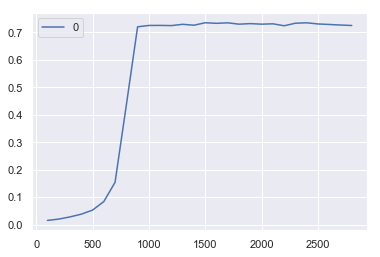

- Also, when I run one frozenlake env with the done flag, I get WORSE performance??? its not too significant but still enough that it surprised me. its likely because the agent gets penalized for exploring as it falls into holes and may learn at least initially to avoid moving... or something
- this run is from num_envs=2
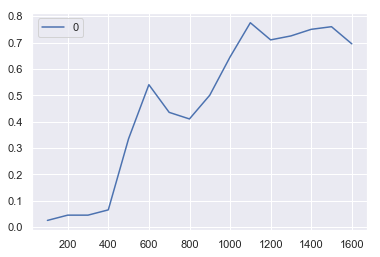


- I think im going to make the time scaling inversely proportional to the square root of the number of environments?
- im still unsure if its the exploration time being cut off that matters or the total data collection time
- i can try leaving the number of exploration steps fixed (n_epsilon) even if the total time doesnt change
- im gonna try something else, which is to make epsilon fixed at 0.1
- im gonna test it out on just the tabular RL notebooks since theyre fast
- interesting! it does much worse than expected. 

- i feel like I may be overfitting to a single problem. im going to move on to using neural networks to solve envs!

25/05/19

- I started to refactor the code for this project because it was getting a little messy, with all these different programs with slightly different names, and not all versions being equal.
- I just rewrote the basic q-learning one, and it seems to work well
- I also rewrote the q-learning using tensorflow and I seem to be having some troubles
- I'm not sure why!
- Okay so it seems like something rather odd is going on. I copy and pasted the working agent from previous iterations to the tensorflow one and it looks like its performing rather poorly. I'm going to see what changes are breaking.
- first im going to check that epsilon decay is working properly
- okay it looks like epsilon decay is going well
- could training somehow differ?
- im gonna try the training loop from the older iteration, making the necessary changes (name changes for placeholders, adding done flags and n )
- weird... the performance still sucks using that training loop. I cant seem to figure out whats going on.
- im gonna try replacing decay epsilon with the old one
- okay what im going to do is take the working one and slowly change it into the other one and we can see where it breaks
- the easiest changes are to change the training code and separate those out into functions
- okay so I changed the training loop and plotting into functions and it still gets around 0.7-0.8 performance, so that means that the training loop isnt what broke it.
- next im going to separate out act, update, and update_epsilon into functions
- oh my god okay it MAY have been a scope issue. ive made sure that the tensorflow uses self.* to refer to variables its initialized with, and it now looks more like the original q-learning agent
- nope, that wasnt the problem. although it probably makes thins a bit nicer :)
- next change: make act(...) a function
- that wasn't breaking. next, ill make the epsilon decay based on a fraction for n
- that wasnt it either!
- ill move update to its own function now
- okay so im unsure if it was the done flags, I may have to set them to 0 by default for a quick check, but that seemed to hurt performance. its not as low ar ~0.5, but it still seemed to hurt it.
- nope, that wasnt it. it still does pretty well! getting around 0.7 for performance.
- time to diff and see whats different...
- OKAY SO I BROKE PEROFRMANCE LEETS SEE WHAT I DID i honestly feel like i just moved a few things around? i did 'undo' im going to move like 1 thing at a time
- waiting takes soooo long.

- wait. Im having a hard time determining if its broken with this or not. im going to have to run it a few times, but i may have to try again...
- okay so the 'done' flag makes a difference on the plain q-learning notebook, so im not sure what to do about that...
- okay so i think it works, the broken one peaks at like 0.4-0.5 whereas the 'working' one is like 0.6-0.8.
- GOD WHAT THE FUCK! Okay i moved some things around and perofrmance tanked.
- Im going to run it one more time and see if that happens again, then compare the working to non working ones.
- after a few runs, I think that its performance is sub-par and isnt doing as well as the tabular RL version, so there is likely a bug.
- god i hate my life wtf! its so hard to find out if this thing is broken or note. sometimes it works well and sometimes it doesnt.

- okay, I genuinely cant tell if something is wrong but it should all be working the exact same.

- OH. the learning rate was 0.8 for tabular and 0.5 for the other two, lets see if that makes a difference.
- i have no idea. im going to try writing the tf one from scratch again.
- 

FUCK ME LOLLOLOLOL OKAY I MADE A TENSORFLOW AGENT BY REWRITING BASED ON THE Q_LEARNING AGENT AND I OVERWROTE THE ORIGINAL Q LEARNING AGENT HAHAHAHAHAHA

but i think it works. what a waste of time lol

- so i basically translated directly from the q-learning one based on numpy to the tensorflow one making some minor changes. i cant really tell or understand the difference between the old program and the new one but whatever, right? honestly debugging this stuff is so tiring.
- okay, I am using tf.assign like tabular RL in tensorflow, but I want to make the change where I use an optimizer.
- okay so that breaks it, and im not 100% sure why
- but the Q table seems to never be updated?
- HAHAHAHAHAHAH I FORGOT TO INCLUDE r_t in my loss function
- okay! looks like they both work. awesome. im very happy.

- 

It looks like I have a basic DQN (without target network or experience replay buffer) working on frozenlake and kind of on cartpole. cartpole works with
```
agent = Agent(state_shape, num_actions, num_envs, alpha=0.0001, gamma=0.95, epsilon_i=1.0, epsilon_f=0.0)
```

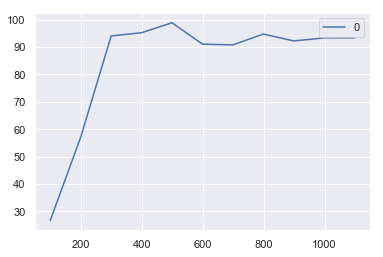

- I am having troubles replicating the above and im not sure why.
- maybe it was a bug? 
- okay i got this again
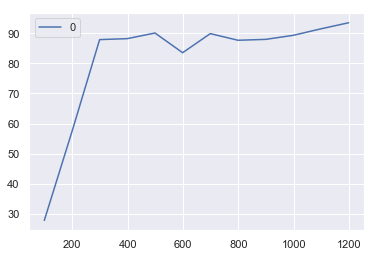
- but I have no idea how to tell whats causing it to work/not work. it could be a bug with not closing sessions..?

- it seems to go between learning well and not learning at all
- weird. okay so i made the session contained within the train method

30/05/19
- ive been doing a bad job logging.
- i started rewriting everything using tf2 (eager)
- i think i got it all working at least for using 1 env, but more seems to bugger it...
- im having that annoying issue i used to have though where the training was poorer for more envs but idk why
- 1 env works fine and 2 envs works terribly.
- 

- I'm not sure why 2 envs breaks it. I forgot about this issue and went and implements q-learning with target networks but forgot about multi-env breaking it. ill have to look into this.


08/06/19

- I finally got back to doing this after moving! 
- I fixed the bug after a while. It was the loss function: i had 0.5*tf.reduce_mean(...)**2 instead of tf.reduce_mean(0.5*...**2)
- i can get to around 90 reward on cartpole again! im not sure how to break past that though.

In [ ]:
num_envs = 32
make_env = lambda: gym.make("CartPole-v0")
env = VectorizedEnvWrapper(make_env, num_envs)
state_shape = env.observation_space.shape
num_actions = env.action_space.n
agent = Agent(num_envs, state_shape, num_actions, alpha=0.01, gamma=0.95, epsilon_i=1.0, epsilon_f=0.0)

rewards = train(env, agent, T=20000)

- honestly it may just need more experience
- also, the averaging might be fucking it up, ill try plotting with a smaller window


- okay so sometimes the agent learns and peaks at around 90 and sometimes it quickly drops to like 10
- i reran training multiple times and it seemed to work eventually?
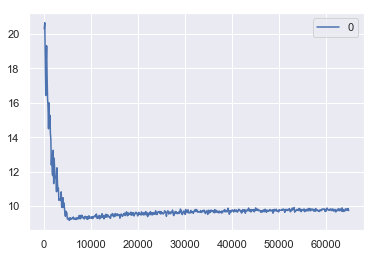

then this one
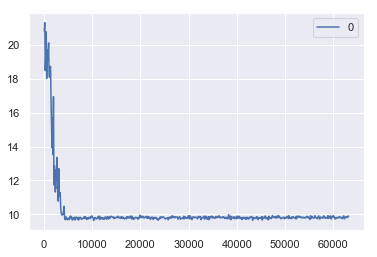

then this one 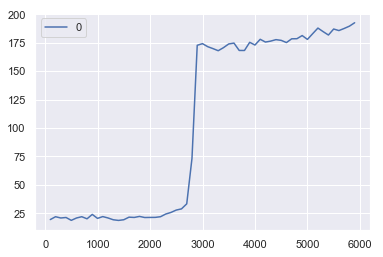

then this one??
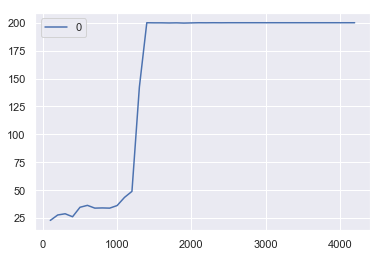

so maybe it just needs way more time?
- i'm not sure how to make it get to 200 performance each time but at least this is proof that MY IMPLEMENTATION IS CORRECT and i dont need to be pulling hairs out...

- i can replicate the above behaviour so its possible the agent is simply not exploring sufficiently? i might need to make exploration last longer. ill try setting n_epsilon higher and the overall timesteps also higher

- oh my god, maybe it's still finnicky because when I reran the notebook i couldnt get the same performance as above...
- okay so here's what im thinking. an agent can get to 200 performance, and then when the next training cycle starts, it drops back down to like... not so good. like this:
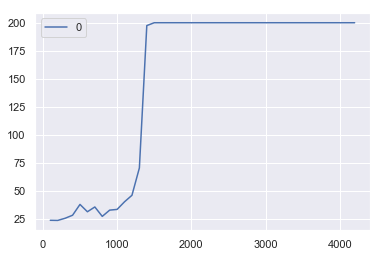

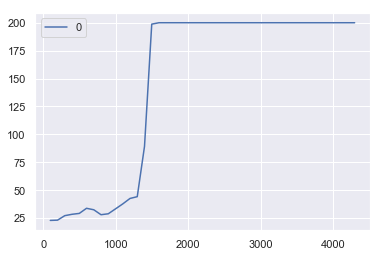

these two images are from conescutive training cycles with the same agent and env being passed in. i think i need to do a deep dive to figure out why this is happening first and foremost.

okay so this is what 'failure mode' looks like to me:
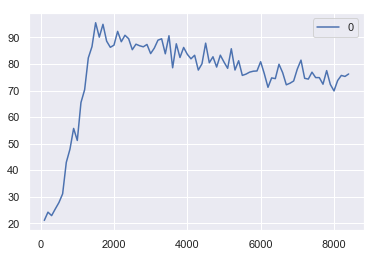

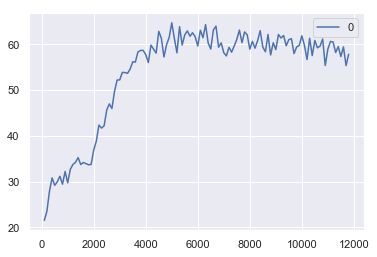

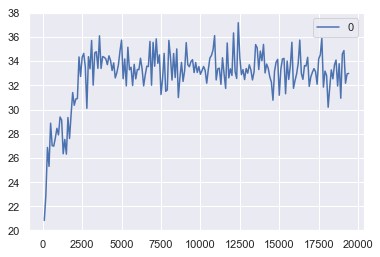

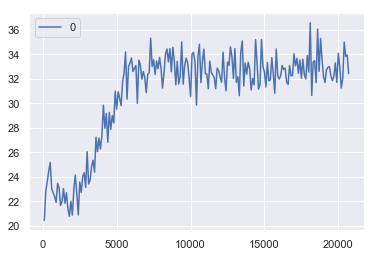

- im not sure what causes it to fail and be brittle.
# Problems
## Learning seems to only happen sometimes (randomly)

Hypotheses:

- bad random seeds
- 

## Rewards are always low at the start of learning even with a trained agent

Hypotheses:
- something in plotting
- something in the env vectorizer

- im going to start by printing rewards during training and tracking which environments are failing.
- okay that was a dumb idea, its hard for me to visualize any of that. rather than continue down that route, im going to see if
    1. it happens with other envs
    2. it happens if i create the env from scratch each time (but keep the agent)

(2) I create the env from scratch for each training cycle and the reward is still low at the beginning. So that must not be the problem. also, i just got a success then a failure mode. so creating them from scratch isnt helping.
(1) im going to try it with the one-hot frozenlake and maybe a one-hot bandits problem.

- also, i doubt it's this but, it *could* be the optimizer...
- okay so with frozenlake, the rewards again are low at the start like this
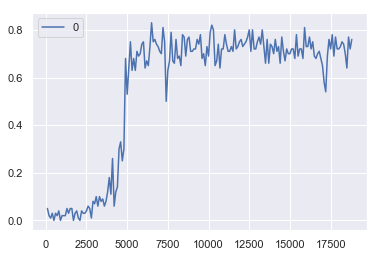

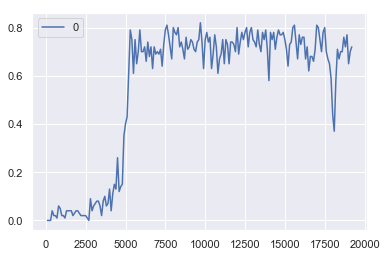

- okay so the low initial rewards it looks like is somehow caused by the agent having its epsilon be reset?
- ill plot epsilon over time to guarantee that its actually changing
- oh i see its based on how i update epsilon. i use t/T. Okay so let's see what happens if i change that to be permanent?
- alright i made the update 'stateful' and tested with exponential decay
- im gonna add optimizer as a parameter and see if i can improve by not using SGD.

10/06/19
- I downloaded someone else's DQN implementation and I'm going to see if I can turn theirs into mine and see where it breaks!
- maybe i need to add experience replay
- ill do that first then try to make one into the other

changelog:
- made other into linear by removing dense layers and using zeros initializer
- it looks like that's giving it a hard time to begin with, so maybe i need to change up my network a little bit!
- its consistently getting like 10 performance
- perhaps it just needs a higher learning rate though to learn so im going to set its learning rate to mine (1e-3 to 1e-2)
- i think mine works after a few runs because we reintroduce exploration several times. i think that that's the main thing. im not sure what makes it only sometimes learn to like ~90 versus other times though.
- i set the exponential epsilon decay to 0.999 instead of 0.995 hopefully giving it more time to explore
- its possible that the linear architecture is just too shallow for it to learn cartpole but that shouldnt really be the case you know? its simple enough
- okay interesting! it looks like the agent is performing terribly so far without hidden layers and with zero initializers with no bias. im going to slowly bring it back to the previous model and see what the biggest difference is.
- OR it could be because id idnt specify input_shape on the only layer i included? ill try that first
- that definitely wasnt it. okay, first im going to bring the learning rate and gamma back to where they were and add in one layer at a time.
- actually first im going to get rid of the zeros initializer
- then ill get rid of use_bias=False if that does nothing
- still no improvement ill add back in one dense layer and see what happens

i think i goofed something let me try all that again

changelog:
1. change final layer initializer to zeros
    - the agent can still learn and this doesn't make a significant difference.
    - it seems to have hurt performance a little bit.
    - runs to solve: 
2. remove bias
    - seems to hurt performance a decent amount but i guess it makes sense because it can allow for some baseline prediction for what $Q$ should be that does not depend on the state? although the other layers have bias in them as well so idk.
    - runs to first 200: 59
3. remove a Dense (hidden) layer
    - this drastically hurts performance.
    - runs to first 200: N/A the agent fails to converge to a good policy.
4. turn off bias for each hidden layer
    - this also drastically hurts performance
    - runs to first 200: N/A the agent fails to converge to a good policy
    - **IM BLOWN AWAY AT HOW MANY SMALL THINGS MAKE OR BREAK THESE PROGRAMS!?**

**next steps**

- oh my god those bastards also have reward shaping! im going to remove that and see if it can still learn
- they also dont run DQN solver if its terminal 

5. remove reward shaping 
    - hurts performance a bit
    - runs to first 200: 48
    - runs to second 200: agent fails to achieve this performance more than once.
    
6. remove reward shaping and ensure training on that by moving trainiing to before 'break'
    - 

- as a sanity check i just ran the original code w/o modifications and it took a while to work (not much longer than the above)
- although it seems to consistently perform better (gets 200 and stays there)
- i mean, thus far im impressed that my network with a single hidden layer does better than this but i cant figure out what makes mine brittle
- 

- ive been slowly transforming working code into mine and i'm having problems with the experience replay!
- wow! lots of work but i have a copy that works (nice! copy6) and i have one that doesn't. the one that doens't work seems to have some kind of faulty replay buffer!
- 